# Model Adversarial Demo

## Import Libraries

In [1]:
import numpy as np
import json, torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models
from torchvision.transforms import transforms
from models.project_models import FC_500_150, LeNet_CIFAR, LeNet_MNIST, Net
from utils.project_utils import get_clip_bounds, evaluate_attack, display_attack

## CIFAR-10 SSL Fix

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

## Set Random Seed & Device

In [3]:
rand_seed = 100
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)

use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

## Download & Pre-Process Datasets

### MNIST Dataset

In [4]:
mnist_mean = 0.5
mnist_std = 0.5
mnist_dim = 28

mnist_min, mnist_max = get_clip_bounds(mnist_mean,
                                       mnist_std,
                                       mnist_dim)
mnist_min = mnist_min.to(device)
mnist_max = mnist_max.to(device)

mnist_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=mnist_mean,
        std=mnist_std)])

mnist_tf_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=mnist_mean,
        std=mnist_std)])

mnist_tf_inv = transforms.Compose([
    transforms.Normalize(
        mean=0.0,
        std=np.divide(1.0, mnist_std)),
    transforms.Normalize(
        mean=np.multiply(-1.0, mnist_std),
        std=1.0)])

mnist_temp = datasets.MNIST(root='datasets/mnist', train=True,
                            download=True, transform=mnist_tf_train)
mnist_train, mnist_val = random_split(mnist_temp, [50000, 10000])

mnist_test = datasets.MNIST(root='datasets/mnist', train=False,
                            download=True, transform=mnist_tf)

### CIFAR-10 Dataset

In [5]:
cifar_mean = [0.491, 0.482, 0.447]
cifar_std = [0.202, 0.199, 0.201]
cifar_dim = 32

cifar_min, cifar_max = get_clip_bounds(cifar_mean,
                                       cifar_std,
                                       cifar_dim)
cifar_min = cifar_min.to(device)
cifar_max = cifar_max.to(device)

cifar_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=cifar_mean,
        std=cifar_std)])

cifar_tf_train = transforms.Compose([
    transforms.RandomCrop(
        size=cifar_dim,
        padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=cifar_mean,
        std=cifar_std)])

cifar_tf_inv = transforms.Compose([
    transforms.Normalize(
        mean=[0.0, 0.0, 0.0],
        std=np.divide(1.0, cifar_std)),
    transforms.Normalize(
        mean=np.multiply(-1.0, cifar_mean),
        std=[1.0, 1.0, 1.0])])

cifar_temp = datasets.CIFAR10(root='datasets/cifar-10', train=True,
                              download=True, transform=cifar_tf_train)
cifar_train, cifar_val = random_split(cifar_temp, [40000, 10000])

cifar_test = datasets.CIFAR10(root='datasets/cifar-10', train=False,
                              download=True, transform=cifar_tf)

cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


### ImageNet Dataset

In [6]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
imagenet_dim = 224

imagenet_min, imagenet_max = get_clip_bounds(imagenet_mean,
                                             imagenet_std,
                                             imagenet_dim)
imagenet_min = imagenet_min.to(device)
imagenet_max = imagenet_max.to(device)

imagenet_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(imagenet_dim),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=imagenet_mean,
        std=imagenet_std)])

imagenet_tf_inv = transforms.Compose([
    transforms.Normalize(
        mean=[0.0, 0.0, 0.0],
        std=np.divide(1.0, imagenet_std)),
    transforms.Normalize(
        mean=np.multiply(-1.0, imagenet_mean),
        std=[1.0, 1.0, 1.0])])

imagenet_test = datasets.ImageNet(root='datasets/imagenet', split='val',
                                  transform=imagenet_tf)

# Maps the ImageNet class index to the ImageNet class name
# [https://discuss.pytorch.org/t/imagenet-classes/4923/2]
class_file = 'datasets/imagenet/imagenet_class_index.json'
with open(class_file, 'r') as file:
    class_idx = json.load(file)
    imagenet_classes = [class_idx[str(k)][1] for k in range(len(class_idx))]

## Dataset Loaders

In [7]:
batch_size = 64
workers = 4

mnist_loader_train = DataLoader(mnist_train, batch_size=batch_size,
                                shuffle=True, num_workers=workers)
mnist_loader_val = DataLoader(mnist_val, batch_size=batch_size,
                              shuffle=False, num_workers=workers)
mnist_loader_test = DataLoader(mnist_test, batch_size=batch_size,
                               shuffle=False, num_workers=workers)

cifar_loader_train = DataLoader(cifar_train, batch_size=batch_size,
                                shuffle=True, num_workers=workers)
cifar_loader_val = DataLoader(cifar_val, batch_size=batch_size,
                              shuffle=False, num_workers=workers)
cifar_loader_test = DataLoader(cifar_test, batch_size=batch_size,
                               shuffle=False, num_workers=workers)

imagenet_loader_test = DataLoader(imagenet_test, batch_size=batch_size,
                                  shuffle=False, num_workers=workers)

## GoogLeNet Evaluation

In [8]:
model = models.googlenet(pretrained=True).to(device)
model.eval()

correct = 0
count = 0

length_dataset = len(imagenet_loader_test.dataset)
length_batches = len(imagenet_loader_test)

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(imagenet_loader_test):
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        correct += (outputs.max(dim=1)[1] == labels).sum().item()
        count += images.shape[0]
        
        if batch_idx % 20 == 0 or batch_idx == (length_batches - 1):
            print('Images Processed : ({:d} / {:d})'\
                .format(count, length_dataset), end='\r')
        
        del images, labels, outputs

test_error = (1.0 - (correct / length_dataset)) * 100.0
print('\nGoogLeNet Test Error : {:.2f}%'.format(test_error))

if device.type == 'cuda':
    torch.cuda.empty_cache()

Images Processed : (50000 / 50000)
GoogLeNet Test Error : 30.22%


## DeepFool Parameters

In [9]:
deep_batch_size = 10
deep_num_classes = 10
deep_overshoot = 0.02
deep_max_iters = 50

deep_args = [deep_batch_size, deep_num_classes,
             deep_overshoot, deep_max_iters]

## MNIST Adversarial Evaluation

### LeNet Model

In [10]:
fgsm_eps = 0.6
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))

evaluate_attack('mnist_lenet_fgsm.csv', 'results',
                device, model, mnist_loader_test,
                mnist_min, mnist_max, fgsm_eps, is_fgsm=True)
print('')
evaluate_attack('mnist_lenet_deepfool.csv', 'results',
                device, model, mnist_loader_test,
                mnist_min, mnist_max, deep_args, is_fgsm=False)

if device.type == 'cuda':
    torch.cuda.empty_cache()

FGSM Test Error : 87.89%
FGSM Robustness : 4.58e-01
FGSM Time (All Images) : 0.29 s
FGSM Time (Per Image) : 28.86 us

DeepFool Test Error : 98.74%
DeepFool Robustness : 9.64e-02
DeepFool Time (All Images) : 193.32 s
DeepFool Time (Per Image) : 19.33 ms


### FC Model

In [11]:
fgsm_eps = 0.2
model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))

evaluate_attack('mnist_fc_fgsm.csv', 'results',
                device, model, mnist_loader_test,
                mnist_min, mnist_max, fgsm_eps, is_fgsm=True)
print('')
evaluate_attack('mnist_fc_deepfool.csv', 'results',
                device, model, mnist_loader_test,
                mnist_min, mnist_max, deep_args, is_fgsm=False)

if device.type == 'cuda':
    torch.cuda.empty_cache()

FGSM Test Error : 87.08%
FGSM Robustness : 1.56e-01
FGSM Time (All Images) : 0.15 s
FGSM Time (Per Image) : 14.99 us

DeepFool Test Error : 97.92%
DeepFool Robustness : 6.78e-02
DeepFool Time (All Images) : 141.81 s
DeepFool Time (Per Image) : 14.18 ms


## CIFAR-10 Adversarial Evaluation

### Network-In-Network Model

In [12]:
fgsm_eps = 0.2
model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))

evaluate_attack('cifar_nin_fgsm.csv', 'results',
                device, model, cifar_loader_test,
                cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
print('')
evaluate_attack('cifar_nin_deepfool.csv', 'results',
                device, model, cifar_loader_test,
                cifar_min, cifar_max, deep_args, is_fgsm=False)

if device.type == 'cuda':
    torch.cuda.empty_cache()

FGSM Test Error : 81.29%
FGSM Robustness : 1.77e-01
FGSM Time (All Images) : 0.67 s
FGSM Time (Per Image) : 67.07 us

DeepFool Test Error : 93.76%
DeepFool Robustness : 2.12e-02
DeepFool Time (All Images) : 185.12 s
DeepFool Time (Per Image) : 18.51 ms


### LeNet Model

In [13]:
fgsm_eps = 0.1
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))

evaluate_attack('cifar_lenet_fgsm.csv', 'results',
                device, model, cifar_loader_test,
                cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
print('')
evaluate_attack('cifar_lenet_deepfool.csv', 'results',
                device, model, cifar_loader_test,
                cifar_min, cifar_max, deep_args, is_fgsm=False)

if device.type == 'cuda':
    torch.cuda.empty_cache()

FGSM Test Error : 91.71%
FGSM Robustness : 8.90e-02
FGSM Time (All Images) : 0.40 s
FGSM Time (Per Image) : 40.08 us

DeepFool Test Error : 87.81%
DeepFool Robustness : 1.78e-02
DeepFool Time (All Images) : 73.27 s
DeepFool Time (Per Image) : 7.33 ms


## ImageNet Adversarial Evaluation

### GoogLeNet Model

In [14]:
fgsm_eps = 0.02
model = models.googlenet(pretrained=True).to(device)

evaluate_attack('imagenet_googlenet_fgsm.csv', 'results',
                device, model, imagenet_loader_test,
                imagenet_min, imagenet_max, fgsm_eps, is_fgsm=True)
print('')
evaluate_attack('imagenet_googlenet_deepfool.csv', 'results',
                device, model, imagenet_loader_test,
                imagenet_min, imagenet_max, deep_args, is_fgsm=False)

if device.type == 'cuda':
    torch.cuda.empty_cache()

FGSM Test Error : 90.18%
FGSM Robustness : 1.82e-02
FGSM Time (All Images) : 23.18 s
FGSM Time (Per Image) : 463.50 us

DeepFool Test Error : 92.87%
DeepFool Robustness : 5.36e-03
DeepFool Time (All Images) : 6498.78 s
DeepFool Time (Per Image) : 129.98 ms


## Display Adversarial Examples

### MNIST

#### LeNet Model

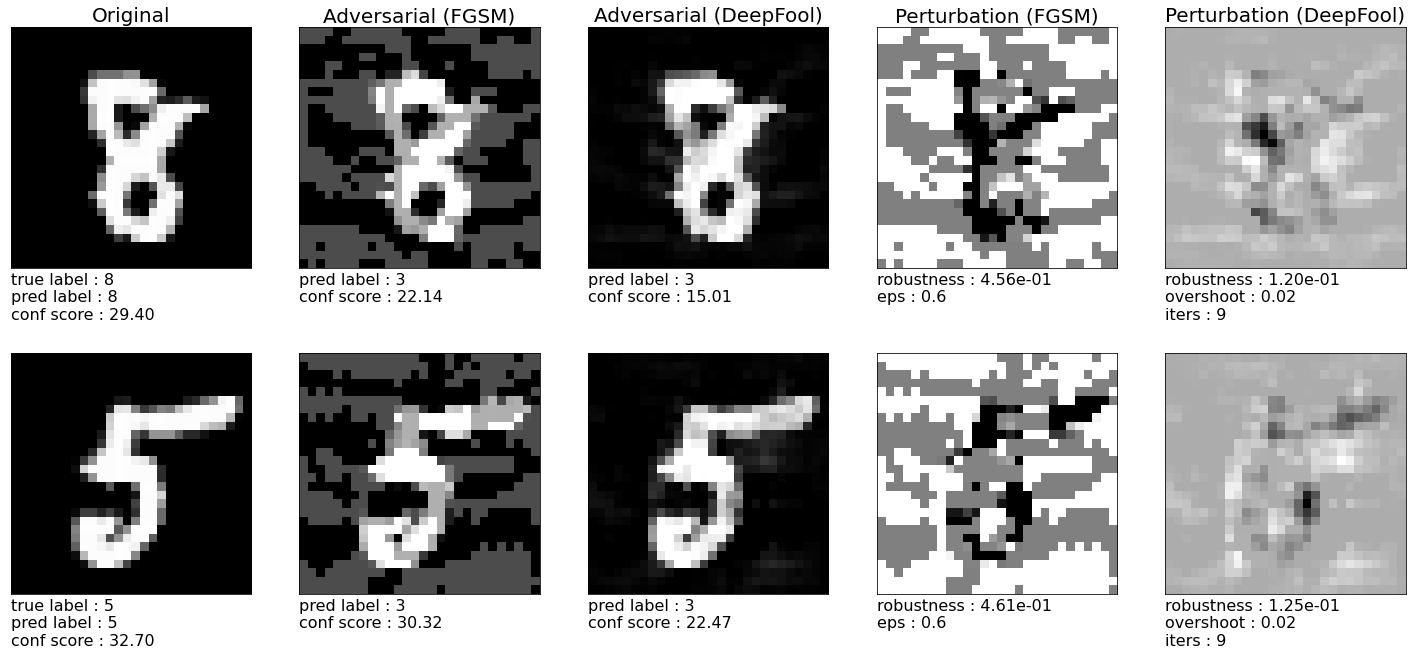

In [15]:
fgsm_eps = 0.6
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))

display_attack(device, model, mnist_test, mnist_tf_inv,
               mnist_min, mnist_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda':
    torch.cuda.empty_cache()

#### FC Model

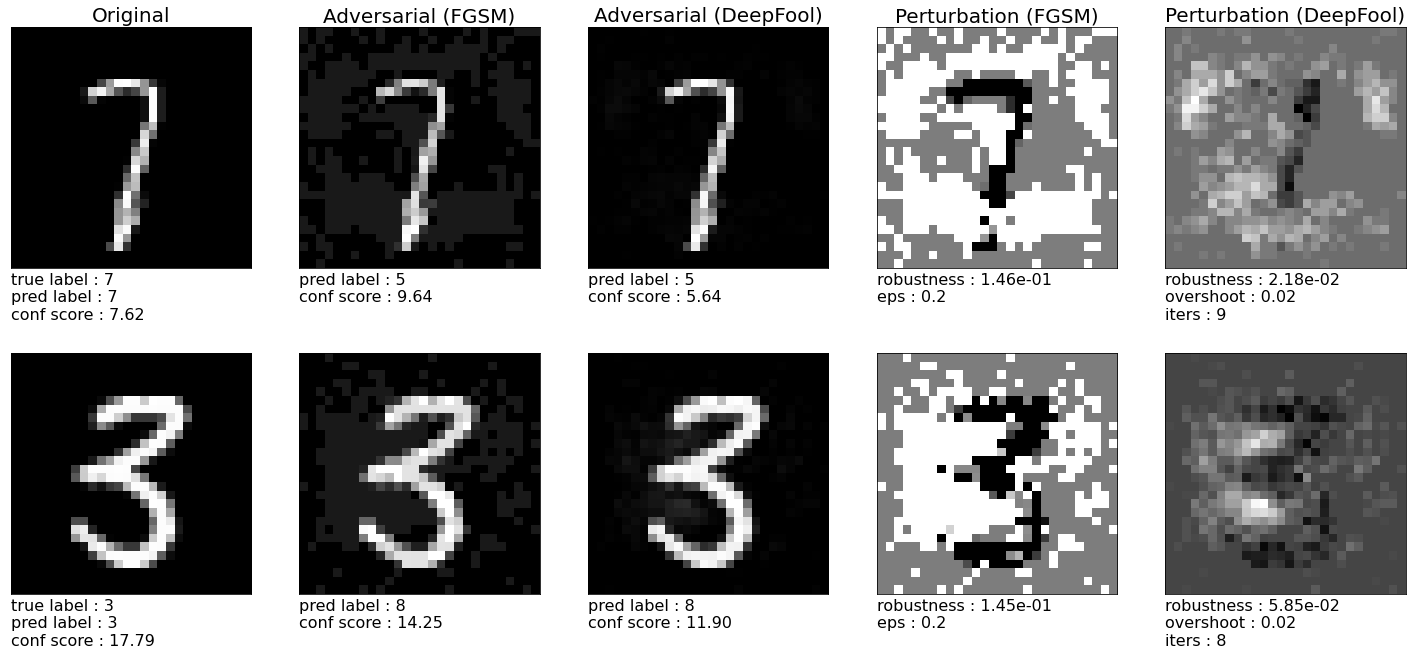

In [16]:
fgsm_eps = 0.2
model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))

display_attack(device, model, mnist_test, mnist_tf_inv,
               mnist_min, mnist_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda':
    torch.cuda.empty_cache()

### CIFAR-10

#### Network-In-Network Model

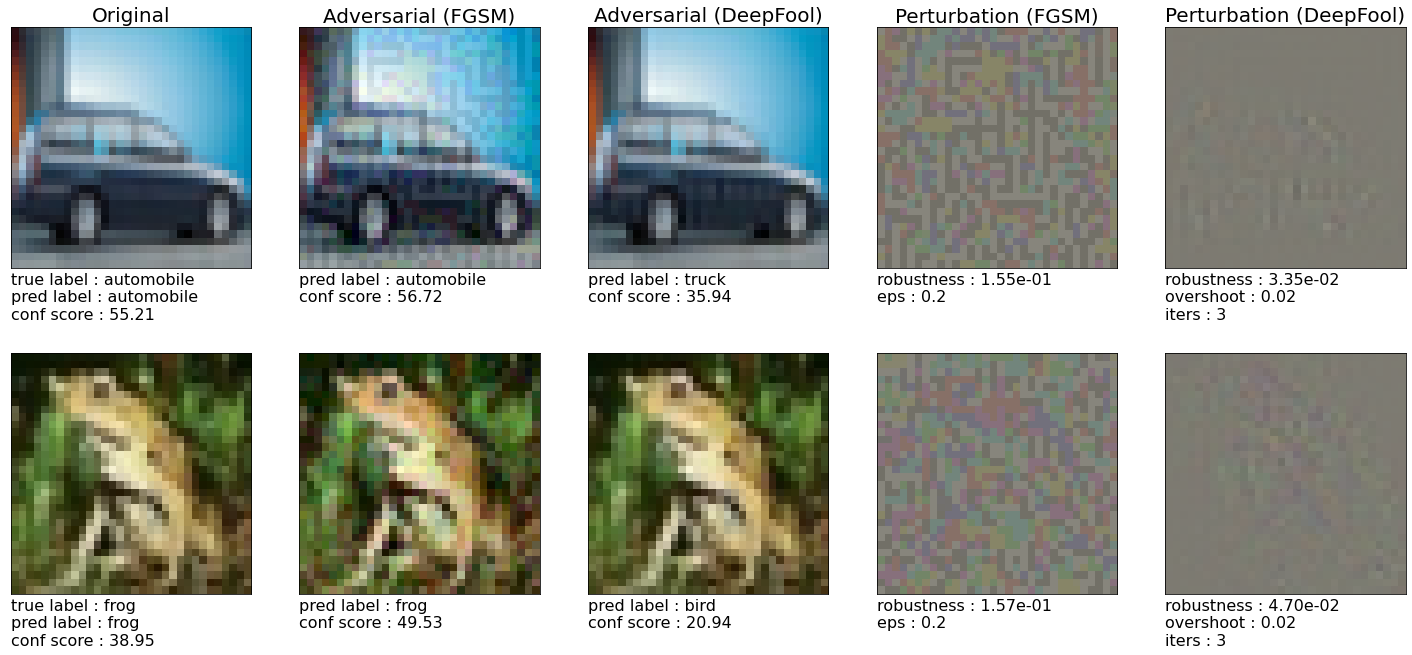

In [17]:
fgsm_eps = 0.2
model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv,
               cifar_min, cifar_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11,
               label_map=cifar_classes)

if device.type == 'cuda':
    torch.cuda.empty_cache()

#### LeNet Model

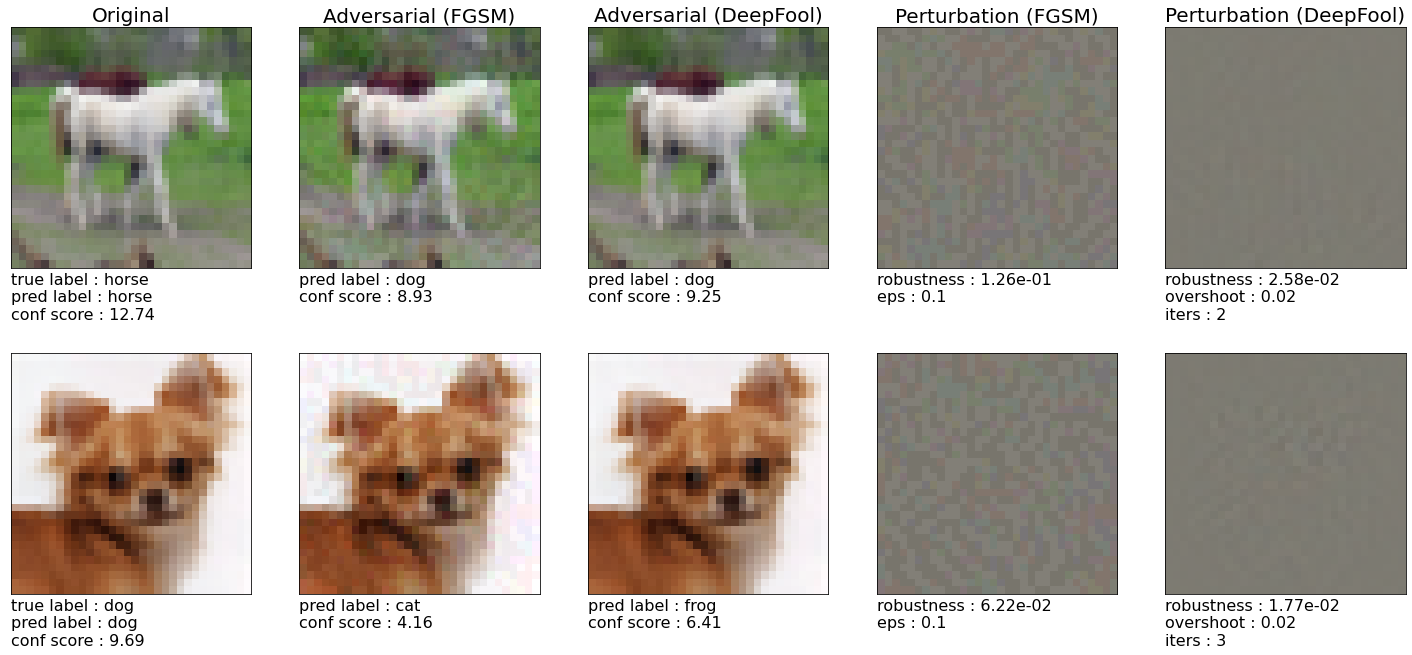

In [18]:
fgsm_eps = 0.1
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv,
               cifar_min, cifar_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11,
               label_map=cifar_classes)

if device.type == 'cuda':
    torch.cuda.empty_cache()

### ImageNet

#### GoogLeNet Model

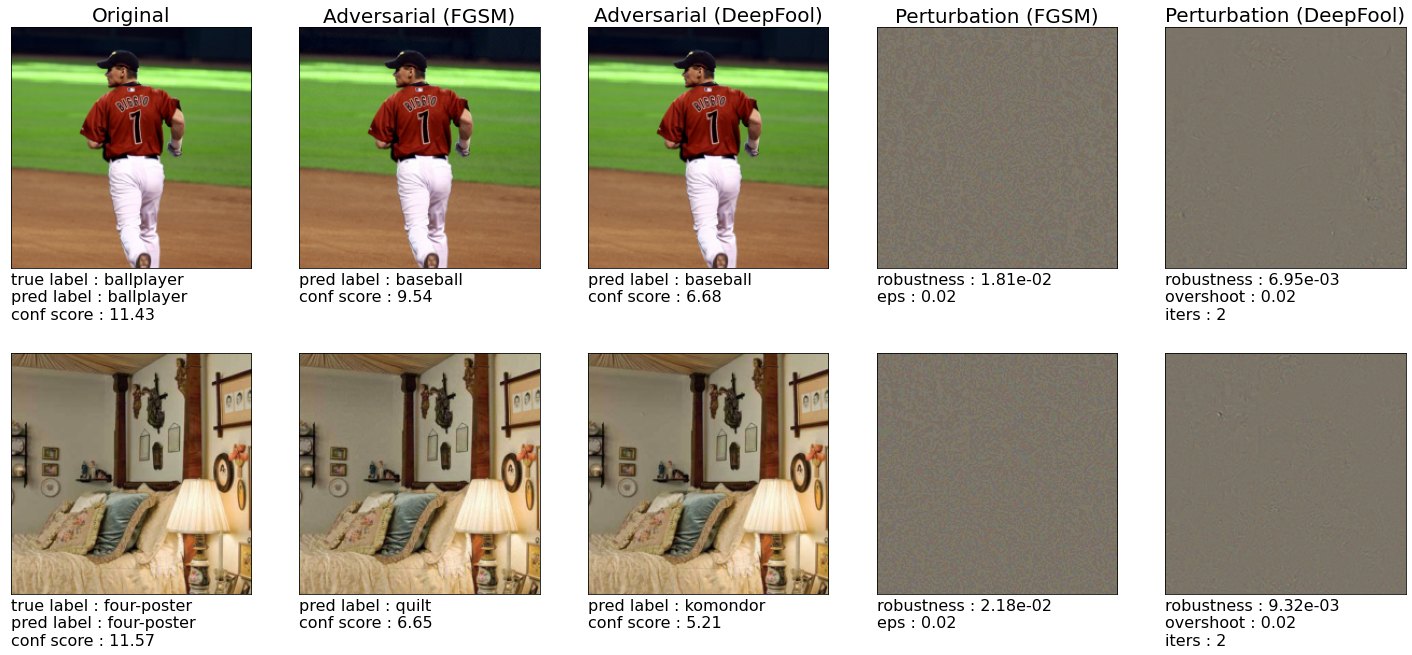

In [19]:
fgsm_eps = 0.02
model = models.googlenet(pretrained=True).to(device)

display_attack(device, model, imagenet_test, imagenet_tf_inv,
               imagenet_min, imagenet_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=5.0,
               fig_rows=2, fig_width=25, fig_height=11,
               label_map=imagenet_classes)

if device.type == 'cuda':
    torch.cuda.empty_cache()